ベイズ推論による機械学習第3章5節「線形回帰の例」を実装する

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from tqdm import tqdm

from scipy.stats import norm

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'IPAPGothic'

%matplotlib inline

### ベイズ推論とは

ベイズ推論では、知りたい事象Xに対してそれを発生させる[確率分布](https://logics-of-blue.com/%E7%A2%BA%E7%8E%87%E5%88%86%E5%B8%83%E3%81%A8%E7%A2%BA%E7%8E%87%E5%A4%89%E6%95%B0%E3%81%AE%E5%9F%BA%E7%A4%8E/)$p(X | \theta)$($\theta$をおいたときにXがおこる確率、後述)を仮定し、その確率分布を形づけるパラメータ$\theta$を求める  
パラメータを求める際には、パラメータの唯一の値$\theta$を求めるのではなく、「パラメータは大体ここら辺に分布している」という確率分布
$$p(\theta)$$
を仮定し、その確率分布を形づけるパラメータを求める  
データ$X$を使って学習させる前のパラメータの確率分布$p(\theta)$を事前分布, 学習させた後のパラメータの確率分布$p(\theta | X)$を事後分布と言う  
これにより、パラメータの不確実性(「パラメータがその値だ」とどれくらい確実に言えるのか)を捉える事が出来る  

例えば、排出確率がわからないガチャを10回回してSSRレアのカードが1回出たとする。この結果から「SSRレアは10%の確率で出る」   

$$
p(SSRレアが当たる| ガチャを回す) = 0.1
$$  

と結論づける事は出来るが、試行回数が少ないため不確実性が高い。  
一方で、その後ガチャを回し続けて合計10000回中SSRが10枚出たとする。「SSRカードは0.1%の確率で出る」  

$$
p(SSRレアが当たる | ガチャを回す) = 0.001
$$  

と結論を出したとき、この結論は試行回数を増やしたため以前より不確実性が低くなっている。このように、未知のパラメータ(この場合はSSRレアの出現確率)に対して期待値だけでなく不確実性(過学習していないか)を考慮出来るのは重要であり、統計学の最尤推定や機械学習の誤差関数最小化アルゴリズムと比べたときの利点の1つ

### ベイズ推論の手順

知りたい事象を発生させる確率分布を形づけるパラメータを$\theta$、知りたい事象の訓練データの集合を$\mathcal{D}$とすると、べイズ推論の手順は以下のようになる  

#### モデルの構築  
まず、$\mathcal{D}$を生成するモデル(生成モデルという)について考える   
$\mathcal{D}$を発生させる確率分布は  
$$p(\mathcal{D} | \theta)$$
となる  
これは条件付き確率と言い、$\theta$が与えられた条件下での$\mathcal{D}$の確率分布$p(\mathcal{D})$を意味する  

グラフィカルモデルにすると、以下のようになる
<img src='../picture/bayesian_inference_graph.png'>
$\theta$から$\mathcal{D}$が生成されているのがわかる  
緑色のノード(変数)は既知、白色のノードは未知の変数を表す

例えば、表=1, 裏=0として1回のコイントスを考えたい場合、Dは過去n回のコイントスの結果  
$$D=\{d_{1}, d_{2}, \ldots, d_{n}\}  \\
d_{i} \in \{0, 1\}
$$    
となり、Dを発生させる確率分布は、1個のパラメータ$\mu \in (0, 1)$から2値を取る変数$d \in \{0, 1\}$を1個生成する確率分布、ベルヌーイ分布をn回掛け合わせたもの
$$
p(\mathcal{D} | \theta) = \prod_{i}^{n} Bern(d_{n} | \mu)  \\
\theta = \mu
$$
となる  
ここで、$\mu \in (0, 1)$等で使われている()は0,1の間で任意の値をとり、$d \in \{0, 1\}$等で使われている{}は0, 1いずれかの値を選択する、$\prod_{i}^{n}$は相乗(全てを掛け合わせる)という意味  

#### 事前分布の設定
次に、求めたいパラメータ$\theta$に関する事前分布$p(\theta)$を設定する  
事前分布を形づけるパラメータ(超パラメータと言う)は適当に設定しておく  
知りたい事象に関する知識があるのならそれらを元に設定してもよいし、特に無ければ出来るだけ分布が特定の場所に偏らないように設定する(無情報事前分布)  
先程のコイントスを考える場合、求めたいパラメータは$\mu \in (0, 1)$となる$\mu$1つなので、ベータ分布を用いる  
$$p(\theta) = p(\mu) = Beta(\mu | a, b) = C_{B}(a, b) \mu^{a-1} (1-\mu)^{b-1}$$  
ベータ分布はa, b2つのパラメータから$\mu \in (0, 1)$となる$\mu$を生成する確率分布  
$C_{B}(a, b)$は正規化項と言い、生成した$\mu$が(0, 1)に収まるように計算結果を調整する、$a, b$によって求められる関数  
無情報事前分布にしたい場合は$a=1, b=1$に設定しておくとベータ分布の形がフラットになる  


#### 事後分布の学習
次に、ベイズの定理   
$$
p(A | B) = \frac{p(B | A)p(A)}{p(B)}
$$  
を用いて
$$p(\theta | \mathcal{D}) = \frac{ p(\mathcal{D} | \theta) p(\theta)}{p(\mathcal{D})}$$  
を求める  
ここで
$$p(\theta | \mathcal{D})$$
は事後分布と言い、事前分布$p(\theta)$が適当に設定した超パラメータ(固定値)のみによって形づけられているのに対し、$p(\theta | \mathcal{D})$は超パラメータと訓練データ$\mathcal{D}$によって形づけられるため、より観測データ$\mathcal{D}$に関する特徴を捉えた確率分布になる事が期待される  
先程のコイントスの例においては、事後分布は事前分布と同じベータ分布の形で表すことが出来、  
$$
p(\theta | \mathcal{D}) = p(\mu | \mathcal{D}) = Beta(\mu | \hat{a}, \hat{b})  \\
\hat{a} = \sum_{i}^{n}d_{i} + a  \\
\hat{b} = n - \sum_{i}^{n}d_{i} + b
$$
となる(計算は省略)  
上の式をみると、事前分布では$a, b$が超パラメータとして固定値しか与えられてなかったのに対し、$\hat{a}, \hat{b}$は固定値$a, b$と訓練データ$\mathcal{D}$が足し合わせられている事がわかる(ベイズ更新)  

#### 予測分布の計算
パラメータを推定するだけでなく、学習させたパラメータを使って予測を行いたい場合がある  
そのような場合は、事後分布$p(\theta | \mathcal{D})$を用いる事で、新たな1つの観測データ$x_{*}$を生成するための予測分布を計算する  
最初にモデル構築をしたときと同じ様に$p(x_{*} | \theta)$を計算し、それらを$\theta$に関して$p(\theta | \mathcal{D})$で重み付け平均を計算するイメージ  
$$
p(x_{*} | \mathcal{D}) = \int p(x_{*} | \theta) p(\theta | \mathcal{D})d\theta
$$  
コイントスの例では、$\mathcal{D}$を生成するためのモデルと同じくベルヌーイ分布の形で表すことが出来、  
$$
\begin{equation}
 \begin{aligned}
p(x_{*} | \mathcal{D}) & = Bern(x_{*} | \frac{\hat{a}}{\hat{a} + \hat{b}})  \\
& = Bern(x_{*} | \frac{\sum_{i}^{n}d_{i} + a}{n + a + b})
 \end{aligned}
\end{equation}
$$ 
となる(計算は省略)

### 回帰分析への応用

#### 回帰分析におけるモデル構築

N個のデータ$\mathbf{x}_{n} \in \mathcal{R}^{M}, y_n \in \mathcal{R}, \mathbf{w} \in \mathcal{R}^{M}$があるとき、M-1次元回帰モデルのグラフィカルモデルは以下  
<img src='../picture/regression_graph.png'>  
このグラフィカルモデルは、$\mathbf{x}_{n}$(M次元ベクトル)と$\mathbf{w}$(M次元ベクトル)によって$y_{n}$(スカラー、値を意味する)が生成される事を意味する(生成モデル)    
回帰分析では、観測可能な$\mathbf{x}_{n}, y_{n}$(緑色のノード、変数を表す)を用いて未観測の$\mathbf{w}$(白色のノード)を学習する  
次元数がM-1となるのは、例えば2次式をベクトルで表したいとき($y=ax^2+bx+c$)、  
$\mathbf{x}=[x^2, x, 1], \mathbf{w}=[a, b, c]$というように定数項を含む3次元ベクトルにする必要があるから  
右上の"N"は囲まれた領域の値がN個ある事を意味する

上記グラフィカルモデルを元に確率分布を仮定して式で表すと以下のようになる  
$$
y_{n} = \mathbf{w}^\intercal \mathbf{x}_n + \epsilon  \\
\epsilon \sim \mathcal{N}(0, \lambda^{-1})  \\
$$  
下の式は$\epsilon$が、平均$\mu = 0$、分散$\sigma^2 = \lambda^{-1}$によって形作られた正規分布$\mathcal{N}(\mu, \sigma^2)$から取り出される事を意味する  
ここで、$\epsilon$は誤差、$\lambda$は精度パラメータ(分布の散らばりを示す分散$\sigma^{2} \in \mathcal{N}^{+}$の逆数、$\lambda = \sigma^{-2}$)  

2式を合体させて確率分布を求めると
$$p(y_{n} | \mathbf{x}_n, \mathbf{w}) = \mathcal{N}(\mathbf{w}^\intercal \mathbf{x}_n, \lambda^{-1})$$  
となる  
$p(y_{n} | \mathbf{x}_n, \mathbf{w})$は、$\mathbf{x}_n, \mathbf{w}$を与えたときに任意の$y_{n}$が帰ってくる確率$p$を表す

今回知りたい$\mathbf{w}$はM次元の連続値を持つので、事前分布に多次元正規分布を仮定する  
これは$\mathbf{m} \in \mathcal{R}^{M}, \mathbf{\Lambda} \in \mathcal{R}^{M \times M}$2つのパラメータから$\mathbf{w} \in \mathcal{R}^{M}$を生成する確率分布
$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{\Lambda}^{-1})$$

モデルを構築した段階で、作ったモデルからデータをサンプリングする事はとても大事  
モデルがどの様なデータを生成するのか確認する事で、学習させようとしているデータに対してモデルの特性が適しているか調べることが出来る  
例えば、3次関数を考える場合、$\mathbf{x}$を任意の数サンプリングするとモデルの形状がどの様に変化するか確かめる

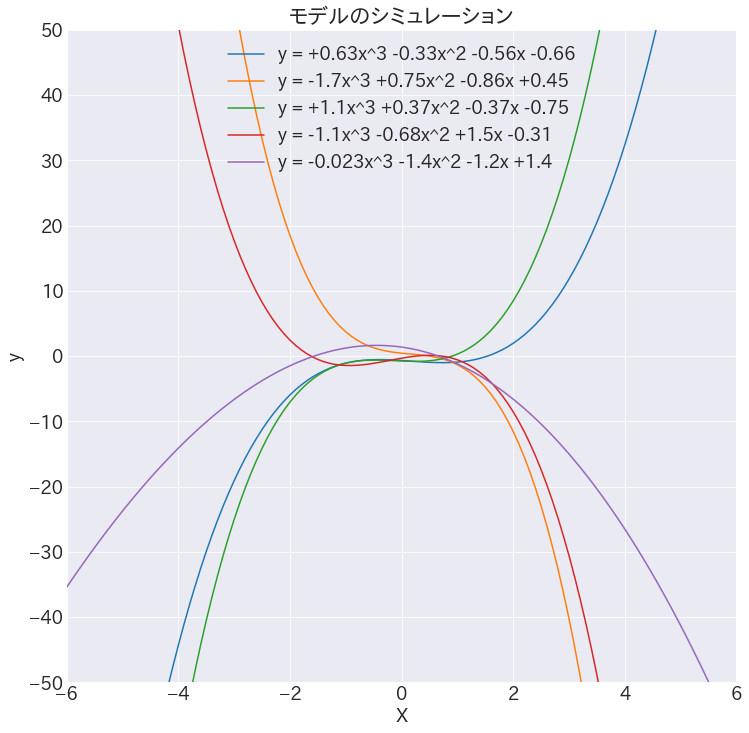

In [12]:
# 3次関数のグラフを考える
# Wの次元数を4にし、xを(1, x, x^2, x^3)とする
# まず適当にMとΛを設定してWをサンプリングする
n_draw = 5
dim = 4

# wをサンプリングするための準備
m_vec = np.zeros(dim)
matLMD_w = np.eye(dim)

# xの作成
x = np.arange(-6, 6.1, 0.1).reshape(1, 121)
matX = np.ones((1, x.shape[1]))
for i in range(1, dim):
    matX = np.append(matX, x**i, axis=0)
    
# wを任意の数サンプリングして、yを計算して、描画を重ねていく
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

# サンプリングしたwに対してループ
for w in np.random.multivariate_normal(m_vec, matLMD_w, n_draw):
    w_vec = w.reshape(4, 1)
    
    y_list = []
    for i in range(x.shape[1]):
        x_vec = matX[:, i].reshape(4, 1)
        y = (w_vec.T @ x_vec).item()
        y_list.append(y)
    
    ax.plot(x.reshape(121), y_list,
            label="y = {:+.2}x^3 {:+.2}x^2 {:+.2}x {:+.2}".format(
                w_vec[3].item(), w_vec[2].item(), w_vec[1].item(), w_vec[0].item()))
    
# 図の体裁を整える
ax.set_xlim(-6, 6)
ax.set_ylim(-50, 50)
ax.set_xticks(np.arange(-6, 6.1, 2))
ax.set_yticks(np.arange(-50, 50.1, 10))
ax.set_title('モデルのシミュレーション')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend()

# plt.savefig('../output/Chapter3/model_simulation.png')
plt.show()

多次元正規分布からサンプリングしてきた5つの$\mathbf{w}$を元に3次関数を描画すると以上の様になる  

次にサンプルのシミュレーションを作る  
任意の1つの3次関数に対して、$\mathbf{x}$を入力すると1次元正規分布から$y$がサンプリングされる様子を描く

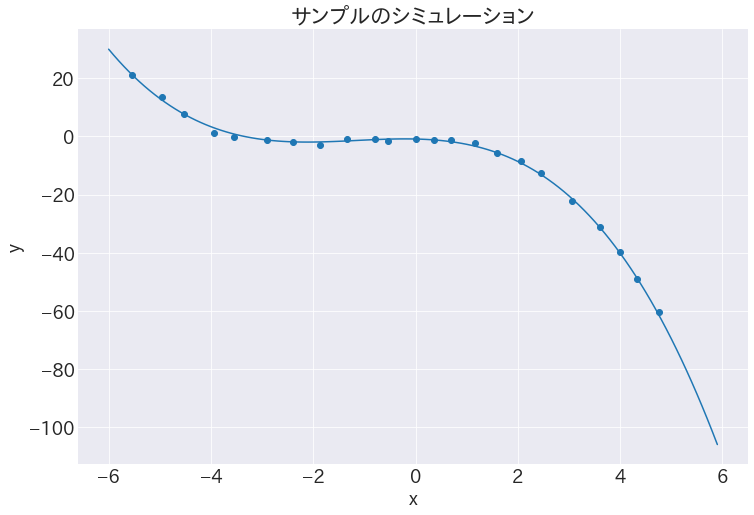

In [73]:
# 次元と固定値を設定
dim = 4
sigma = 1

# wをサンプリングするための超パラメータ
m_vec = np.zeros(dim)
matLMD_w = np.eye(dim)

# wを一つサンプリング
w_vec = np.random.multivariate_normal(m_vec, matLMD_w, 1)

# 関数描画用のxと、yをサンプリングするためのxを作る
x_func = np.arange(-6, 6, 0.1)
x_sampling = []
x_begin = -6
for i in np.random.normal(0.5, 0.1, 23):
    x_begin = x_begin + i
    x_sampling.append(x_begin)
x_sampling = np.array(x_sampling)
    
matX_func = np.ones((1, x_func.shape[0]))
for d in range(1, dim):
    matX_func = np.append(matX_func, (x_func ** d).reshape(1, matX_func.shape[1]), axis=0)
    
matX_sampling = np.ones((1, x_sampling.shape[0]))
for d in range(1, dim):
    matX_sampling = np.append(matX_sampling, (x_sampling ** d).reshape(1, matX_sampling.shape[1]), axis=0)
    
y_func = (w_vec @ matX_func).flatten()
    
# 3次関数を描画する
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x_func, y_func)

# x_sampling, w_vecからyをサンプリングして、重ねる
y_sampling = np.random.multivariate_normal((w_vec @ matX_sampling).flatten(), sigma * np.eye(23))
ax.scatter(x_sampling, y_sampling)

ax.set_title('サンプルのシミュレーション')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

適当にxを与えた場合、関数に沿ってyがサンプリングされている事がわかる

次にデータを与えてモデルを学習、学習済みの関数と予測分布を描く  
今回はsin波からデータをサンプリングする    

#### ベイズ推論に基づく回帰分析の実行

訓練データをサンプリングし、前節で示したモデルに学習させる  
$\mathbf{w}$を求めたり、未知のデータ$x_*$を与えたときの$y_*$を予測する

##### 学習用データのサンプリング

訓練データを$\mathbf{X} = \{x_1, x_2, \ldots, x_{10}\}$, $\mathbf{Y} = \{y_1, y_2, \ldots, y_{10}\}$とする

In [514]:
# 学習用データのサンプル数を設定
n_data = 10

In [97]:
# sin波からxをサンプリングする
# [0, 1]の一様分布からn個サンプルを持ってきて7倍する
# データ数はあらかじめ指定しておく
x_data = np.random.beta(1, 1, n_data) * 7
y_data = np.sin(x_data)

##### モデルの次元数、初期パラメータ(固定)の設定

In [765]:
# 次元数の設定
# 関数の次元数+定数項(1)を与える
dim = 10

In [766]:
# 固定パラメータを設定
m_vec = np.zeros(dim).reshape(dim, 1)
matLMD = np.eye(dim)

lmd = 1

##### 訓練データの加工

In [767]:
# (1, X, X^2,　..., X^dim)のベクトルにする
matX_data = np.ones((1, n_data))
for i in range(1, dim):
    matX_data = np.append(matX_data, (x_data ** i).reshape(1, n_data), axis=0)

##### 訓練データの描画

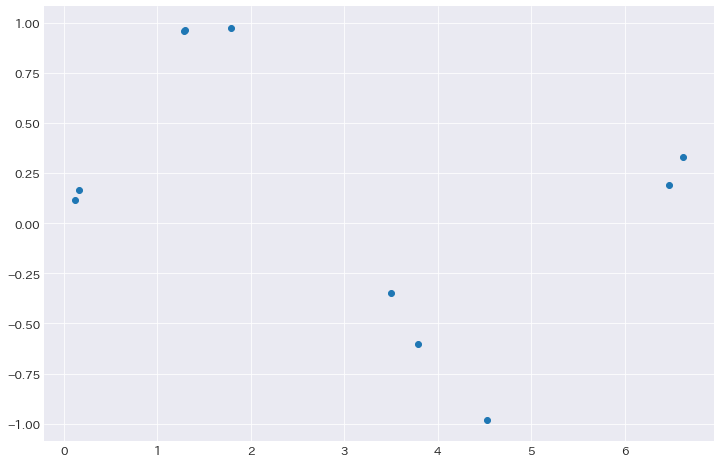

In [768]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.scatter(x_data, y_data)

plt.show()

訓練データを描画するとこんな感じになる  
このデータにモデルを学習させていく

##### 描画用のデータの作成

In [769]:
# 描画・予測用のデータの作成
x_plot = np.arange(0, 7, 0.1)

matX_plot = np.ones((1, x_plot.shape[0]))
for i in range(1, dim):
    matX_plot = np.append(matX_plot, (x_plot ** i).reshape(1, x_plot.shape[0]), axis=0)

##### 事前分布を用いた予測

初期パラメータの情報だけでも、未知のyに対して予測をする事が出来る  
ある$\mathbf{x}_{*}$を与えたとき、$y_{*}$を予測すると、確率分布は  
$$
p(y_{*} | \mathbf{x}_{*}) = \mathcal{N}(\mu, \lambda_{*}^{-1})  \\
\mu_{*} = \mathbf{m}^\intercal \mathbf{x}_{*}  \\
\lambda_{*}^{-1} = \lambda ^{-1} + \mathbf{x}_{*}^\intercal \mathbf{\Lambda}^{-1} \mathbf{x}_{*}
$$  
となる

In [770]:
# 全てのmatX_plotに対して予測を行う
# 学習する前なので、事前に与えたパラメータのみを用いて予測を行う
# データに対する事前知識がある場合は固定パラメータに対しある程度アタリをつけておく事が出来る
# 今回は事前知識を与えないので、フラットな図になるはず
matY_before = np.empty((3, 0))
for i in range(matX_plot.shape[1]):
    # 学習後の予測分布のパラメータを計算
    x_vec_plot = matX_plot[:, i].reshape(dim, 1)
    mu_before = (m_vec.T @ x_vec_plot).item()
    sgm_before = ((1/lmd) + x_vec_plot.T @ np.linalg.solve(matLMD, x_vec_plot)).item()
    # 予測分布を書くためのベクトルを作成
    # 50%信頼区間も描画する
    lower, upper = norm.interval(alpha=0.50, loc=mu_before, scale=sgm_before)
    y_vec_before = np.array([lower, mu_before, upper]).reshape(3, 1)
    matY_before = np.append(matY_before, y_vec_before, axis=1)

##### 事前分布を用いた予測モデルの描画

In [771]:
# 図に書き込むモデル式
m_vec_rev_before = m_vec[::-1]

model_str = '{:+.2}'.format(m_vec_rev_before[0].item())
for i in range(1, dim):
    model_str = '{:+.2}x^'.format(m_vec_rev_before[i].item()) + str(i) + model_str

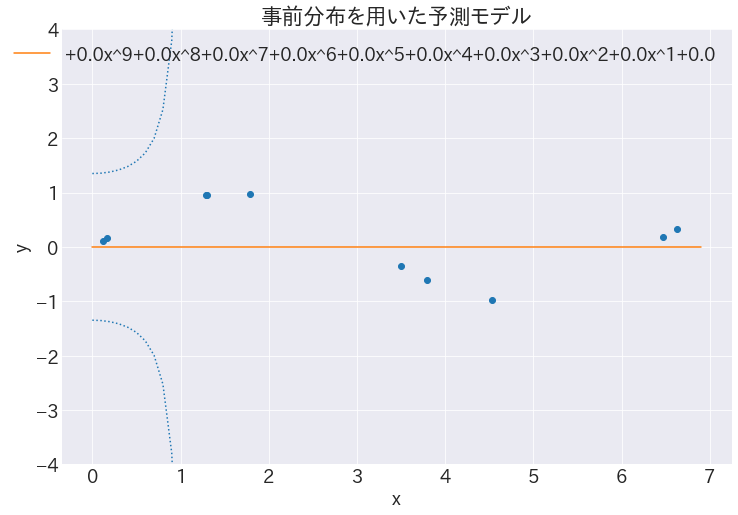

In [772]:
# 学習前のモデルの描画
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(matX_plot[1], matY_before[0], linestyle=':', color='C0')
ax.plot(matX_plot[1], matY_before[1], label=model_str, color='C1')
ax.plot(matX_plot[1], matY_before[2], linestyle=':', color='C0')
ax.scatter(x_data, y_data)

ax.set_ylim(-4, 4)
ax.set_title('事前分布を用いた予測モデル')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()
plt.show()

青い破線は50%信頼区間  
事前分布だけでは何も学習が進んでいない事がわかる  

##### サンプルデータで学習

学習後の事後分布$p(\mathbf{w} | \mathbf{X}, \mathbf{Y})$とそれを形づくるパラメータは  
$$
p(\mathbf{w} | \mathbf{X}, \mathbf{Y}) = \mathcal{N}(\mathbf{w} | \hat{\mathbf{m}}, \hat{\mathbf{\Lambda}}^{-1})  \\
\hat{\mathbf{\Lambda}} = \lambda \sum_{n=1}^{N}\mathbf{x}\mathbf{x}^\intercal + \mathbf{\Lambda}  \\
\hat{\mathbf{m}} = \hat{\mathbf{\Lambda}}^{-1} ( \lambda \sum_{n=1}^{N} y_{n}\mathbf{x} + \mathbf{\Lambda} \mathbf{m} )
$$  
となる

In [773]:
# 学習後のパラメータを設定
# 事後分布p(w | x)を形づくる正規分布N(w | m, lambda)のパラメータを計算する

matLMD_after = lmd * np.array(
    [matX_data[:, i].reshape(dim, 1) @ matX_data[:, i].reshape(1, dim) for i in range(n_data)]).sum(axis=0) + matLMD
m_vec_after = np.linalg.inv(matLMD_after) @ (
        lmd * np.array([y_data[i] * matX_data[:, i].reshape(dim, 1) for i in range(n_data)]).sum(axis=0) + matLMD @ m_vec)

##### 事後分布を用いた予測

初期パラメータで予測した際の  

$$
p(y_{*} | \mathbf{x}_{*}) = \mathcal{N}(\mu, \lambda_{*}^{-1})  \\
\mu_{*} = \mathbf{m}^\intercal \mathbf{x}_{*}  \\
\lambda_{*}^{-1} = \lambda ^{-1} + \mathbf{x}_{*}^\intercal \mathbf{\Lambda}^{-1} \mathbf{x}_{*}
$$  

で使用した$\mathbf{w}$の超パラメータ$\mathbf{m}, \mathbf{\Lambda}$を、学習後の$\hat{\mathbf{m}}, \hat{\mathbf{\Lambda}}$に取り替えて同じ計算をすれば良い 

In [774]:
# 全てのmatX_predに対して再び予測を行う
matY_pred = np.empty((3, 0))
for i in range(matX_plot.shape[1]):
    # 学習後の予測分布のパラメータを計算
    x_vec_plot = matX_plot[:, i].reshape(dim, 1)
    mu_pred = (m_vec_after.T @ x_vec_plot).item()
    sgm_pred = ((1/lmd) + x_vec_plot.T @ np.linalg.solve(matLMD_after, x_vec_plot)).item()
    # 予測分布を書くためのベクトルを作成
    # 平均線と50%信頼区間(両側)を求める
    # 今回は予測分布なのでt分布を用いる
    lower, upper = norm.interval(alpha=0.50, loc=mu_pred, scale=sgm_pred)
    y_vec_pred = np.array([lower, mu_pred, upper]).reshape(3, 1)
    matY_pred = np.append(matY_pred, y_vec_pred, axis=1)

##### 事後分布を用いた予測モデルの描画

In [775]:
m_vec_rev_after = m_vec_after[::-1]

model_str = '{:+.2}'.format(m_vec_rev_after[0].item())
for i in range(1, dim):
    model_str = '{:+.2}x^'.format(m_vec_rev_after[i].item()) + str(i) + model_str

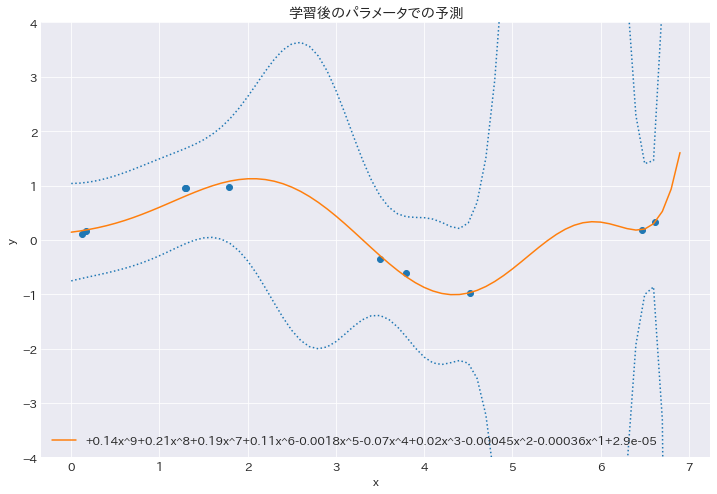

In [776]:
# 学習後のモデルの描画
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(matX_plot[1], matY_pred[0], linestyle=':', color='C0')
ax.plot(matX_plot[1], matY_pred[1], label=model_str, color='C1')
ax.plot(matX_plot[1], matY_pred[2], linestyle=':', color='C0')
ax.scatter(x_data, y_data)

ax.set_ylim(-4, 4)
ax.set_title('学習後のパラメータでの予測')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()
#plt.savefig('../output/dim12.jpg')
plt.show()

学習が進み、モデルがデータの特徴を掴んでいる事がわかる  
青い破線は50%信頼区間

モデルの次元数Mを変えてみると、以下の様になる

<img src='../output/dim_combine.jpg'>

左上: 1次関数  
右上: 2次関数  
左下: 3次関数  
右下: 11次関数  
右下を見ると、11次関数はサンプルデータに対する当てはまり具合は一番高いものの、50%信頼区間が大きく広がっているので、yの値に関して不確実性が高いことを示している  

複数のモデルから一番よいものを選ぶときには[モデルエビデンス]('http://ibisforest.org/index.php?%E3%83%99%E3%82%A4%E3%82%BA%E5%9B%A0%E5%AD%90')を使う  

モデルの集合を$\mathcal{M} = \{M_1, M_2, \ldots, M_K\}$、訓練データの集合を$\mathcal{D}$とすると、各モデル$M_{k}$のモデルエビデンスは  
$$
p(\mathcal{D} | M_{k})  \\
k = 1, 2, \ldots, K
$$

となる  
つまり、モデルエビデンスはモデル$M_k$を与えたときに訓練データ$\mathcal{D}$が発生する尤もらしさを表し、これが一番高くなるモデルを選択すればよい

##### モデルエビデンスを用いた最適なモデルの選択

$p(\mathcal{D} | M_k)$を最大化する事と$\ln p(D | M_k)$を最大化することは同値なので、計算が容易になる$\ln p(D | M)$を最大化する事を考える  
ここで$\ln$とは底がeの対数(log)を取る事を意味する  

回帰分析の例だと、訓練データは$\mathbf{X}, \mathbf{Y}$なので、モデルエビデンスは
$$
\ln p(\mathcal{D} | M_k) = \ln p(\mathbf{X}, \mathbf{Y} | M_k) = - \frac{1}{2} \{\sum_{n=1}^{N}(\lambda y_n^2 - \ln \lambda + \ln 2\pi) + \mathbf{m}^\intercal \mathbf{\Lambda} \mathbf{m} - \ln |\mathbf{\Lambda}| - \hat{\mathbf{m}}^\intercal \hat{\mathbf{\Lambda}} \hat{\mathbf{m}} + \ln |\hat{\mathbf{\Lambda}}| \}
$$

In [777]:
M = dim

In [778]:
model_evidence = - 1/2 * ((lmd * y_data ** 2 - np.log(lmd) + np.log(2 * np.pi)).sum() + m_vec.T @ matLMD @ m_vec -\
                                np.log(np.linalg.det(matLMD)) - m_vec_after.T @ matLMD_after @ m_vec_after + np.log(np.linalg.det(matLMD_after)))
model_evidence = model_evidence.item()

In [779]:
model_evidence

-53.73002179163312

ここまで  
以下は、なんでマイナスになるのか中身を確認

試しに別の角度から同じ計算をしてみる→計算ミスは見られない  
Mを変えて折れ線グラフを書いてみる

In [780]:
#from collections import defaultdict

In [781]:
#mod_evi_dic = defaultdict()

In [782]:
mod_evi_dic[M] = model_evidence

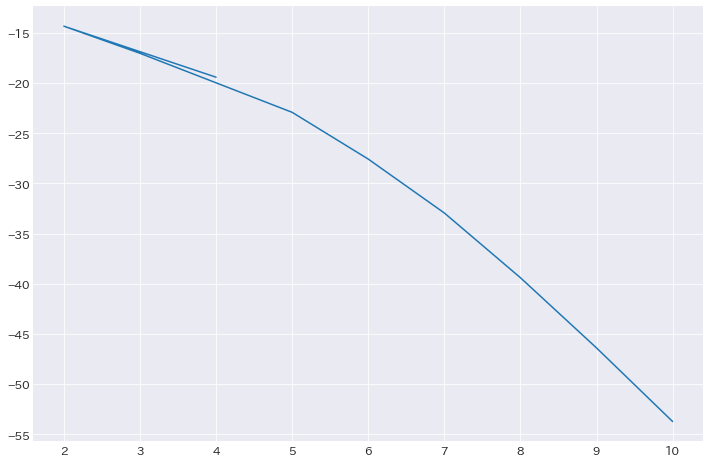

In [790]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(mod_evi_dic.keys(), mod_evi_dic.values())

plt.show()

In [788]:
mod_evi_dic.keys()

dict_keys([4, 2, 3, 5, 6, 7, 8, 9, 10])

In [789]:
mod_evi_dic.values()

dict_values([-19.403684505559355, -14.31745808326934, -17.021100904985765, -22.905458163957057, -27.566055668181107, -32.94003932538831, -39.39362137304435, -46.3914158667099, -53.73002179163312])

In [791]:
tmp = pd.Series([1, 1, 4, 5, 1, 4])

In [792]:
tmp.shape

(6,)

In [796]:
8343940*4/60/60

9271.044444444444

In [797]:
9271/24

386.2916666666667